
# Getting started

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
import pandas as pd

import numpy as np
## Load the data into a DataFrame
liquor = pd.read_csv('../../../../Iowa_Liquor_sales_sample_10pct.csv')[['Store Number',
               'City',
               'Zip Code',
               'County Number',
               'County',
               'Bottle Volume (ml)', 
               'State Bottle Cost', 
               'State Bottle Retail', 
               'Bottles Sold', 
               'Sale (Dollars)', 
               'Volume Sold (Liters)', 
               'Volume Sold (Gallons)']]


In [2]:
## Make necessary column modifications

## Transform the dates
# liquor["Date"] = pd.to_datetime(liquor["Date"], format="%m/%d/%Y")
# liquor['Year'] = liquor['Date'].dt.year
# liquor['Month'] = liquor['Date'].dt.month

## Reformat column names to replace spaces with underscores
liquor.columns = [c.replace(' ', '_') for c in liquor.columns]
liquor.columns = [c.replace(')', '') for c in liquor.columns]
liquor.columns = [c.replace('(', '') for c in liquor.columns]

## turn to lowercase because I hate initcap
liquor.columns = [c.lower() for c in liquor.columns]

In [3]:
## capitalize city and county for consistency
# liquor.city = liquor.city.str.upper()
# liquor.county = liquor.county.str.upper()

# liquor.apply(lambda x: x.astype(str).str.upper())


## remove dollar signs and convert to floats
liquor['sale_dollars'] = liquor['sale_dollars'].str.replace('$','').astype(np.float64)
liquor['state_bottle_retail'] = liquor['state_bottle_retail'].str.replace('$','').astype(np.float64)
liquor['state_bottle_cost'] = liquor['state_bottle_cost'].str.replace('$','').astype(np.float64)

In [14]:
## check: missing values, dtypes, df shape, describe, unique values, duplicates

def eda(dataframe):
    
    print "missing values \n", dataframe.isnull().sum()## count number of null values per column
    print ''
    print "dataframe types \n", dataframe.dtypes       ## list data type of each column
    print ''
    print "dataframe shape \n", dataframe.shape        ## rows by columns
    print ''
    print "dataframe describe \n", dataframe.describe()## stats -- mean, min, max, etc.. 
    print ''
    for item in dataframe:                             ## count number of unique values per column
        print item, '= ', dataframe[item].nunique()
    print ''
    print 'num duplicates:', dataframe.duplicated().sum()

eda(liquor)

missing values 
store_number             0
city                     0
zip_code                 0
county_number          970
county                 970
bottle_volume_ml         0
state_bottle_cost        0
state_bottle_retail      0
bottles_sold             0
sale_dollars             0
volume_sold_liters       0
volume_sold_gallons      0
dtype: int64

dataframe types 
store_number             int64
city                    object
zip_code                object
county_number          float64
county                  object
bottle_volume_ml         int64
state_bottle_cost      float64
state_bottle_retail    float64
bottles_sold             int64
sale_dollars           float64
volume_sold_liters     float64
volume_sold_gallons    float64
dtype: object

dataframe shape 
(174402, 12)

dataframe describe 
        store_number  county_number  bottle_volume_ml  state_bottle_cost  \
count  174402.000000  173432.000000     174402.000000      174402.000000   
mean     3655.515871      56.767021    

In [4]:
## drop duplicate rows
liquor.drop_duplicates(inplace=True)
print 'num duplicates:', liquor.duplicated().sum()

## look into missing county_numbers and counties
county_lookup = liquor[['zip_code','county','county_number']][liquor.county.isnull()==False]
county_lookup.drop_duplicates(inplace=True)

num duplicates: 0


In [6]:
## grabs a list of zip codes for iows to help fill in missing county names
iowa_zips = pd.read_csv('../../../../iowa_zips.csv')
iowa_zips.columns = [c.replace(' ', '_') for c in iowa_zips.columns]
iowa_zips.columns



Index([u'Zip_Code', u'City', u'County'], dtype='object')

In [16]:
# set up connection to SQLalchemy
from sqlalchemy import create_engine
engine = create_engine('sqlite:///:memory:')
conn = engine.connect()

# push dfs into sql tables
liquor.to_sql('liquor', engine)
county_lookup.to_sql('county_lookup', engine)
iowa_zips.to_sql('iowa_zips', engine)

In [17]:
# run updates to fill in county names
conn.execute("update liquor set county = (select county from county_lookup where county_lookup.zip_code = liquor.zip_code) where county is null;")
conn.execute("update liquor set county = (select County from iowa_zips where iowa_zips.Zip_Code = liquor.zip_code) where county is null;")
# run updates to fill in county_numbers
conn.execute("update liquor set county_number = (select county_number from county_lookup where county_lookup.zip_code = liquor.zip_code and county_lookup.county = liquor.county) where county_number is null;")

# pull sql table into a pandas df
liquor_sql = pd.read_sql_table('liquor',engine)
# close sql connection
conn.close()

In [18]:
# check missing values for counties
eda(liquor_sql)

liquor_sql['zip_code'][liquor_sql.county.isnull()==True]
liquor = liquor_sql

missing values 
index                   0
store_number            0
city                    0
zip_code                0
county_number          12
county                  0
bottle_volume_ml        0
state_bottle_cost       0
state_bottle_retail     0
bottles_sold            0
sale_dollars            0
volume_sold_liters      0
volume_sold_gallons     0
dtype: int64

dataframe types 
index                    int64
store_number             int64
city                    object
zip_code                object
county_number          float64
county                  object
bottle_volume_ml         int64
state_bottle_cost      float64
state_bottle_retail    float64
bottles_sold             int64
sale_dollars           float64
volume_sold_liters     float64
volume_sold_gallons    float64
dtype: object

dataframe shape 
(174402, 13)

dataframe describe 
               index   store_number  county_number  bottle_volume_ml  \
count  174402.000000  174402.000000  174390.000000     174402.000000   
me

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


liquor_lite = liquor.groupby(['store_number','city','county','zip_code']).agg({'sale_dollars': np.sum,
                                                                'volume_sold_liters':np.sum,
                                                                'bottles_sold' : np.sum})


In [178]:
# sales_by_ym = liquor[['year','month','sale_dollars']].groupby(['year','month']).agg({'sale_dollars': np.sum})
pd.set_eng_float_format(accuracy=10, use_eng_prefix=True)
sales_by_county = ['county','sale_dollars','volume_sold_liters','bottles_sold']
sales_by_store = ['store_number','sale_dollars','volume_sold_liters','bottles_sold']
# liquor[sales_by_county].groupby(['county']).sum().plot.barh()

## find the counties spending the most on liquor
liquor[['county','sale_dollars']].groupby(['county']).sum().sort_values('sale_dollars',ascending=False)[0:5]


liquor['store_number'][liquor.county.isin(['POLK'])].count()
# ,'LINN','SCOTT']


# liquor[sales_by_store].groupby(['store_number']).sum().plot.barh()

0

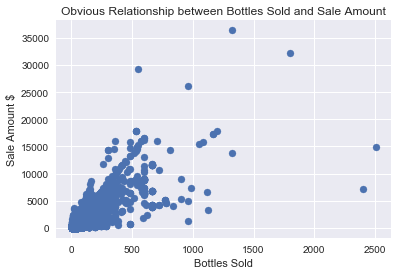

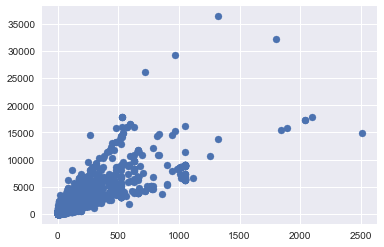

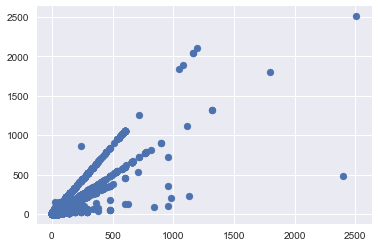

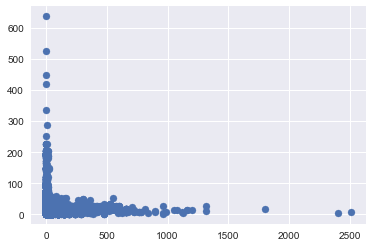

In [161]:
plt.scatter(liquor.bottles_sold,liquor.sale_dollars)
plt.xlabel('Bottles Sold')
plt.ylabel('Sale Amount $')
plt.title('Obvious Relationship between Bottles Sold and Sale Amount')
plt.show()

plt.scatter(liquor.volume_sold_liters,liquor.sale_dollars)
plt.show()

plt.scatter(liquor.bottles_sold,liquor.volume_sold_liters)
plt.show()

plt.scatter(liquor.bottles_sold,liquor.state_bottle_retail)
plt.show()


# Record your findings

Be sure to write out any observations from your exploratory analysis.


In [10]:
import seaborn as sns
liquor_lite

# Mine the data

Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations here for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.
 


In [47]:
## bottles sold
## price per bottle
## total sales
## volume sold
## 

# Index([u'index', u'store_number', u'city', u'zip_code', u'county_number',
#        u'county', u'bottle_volume_ml', u'state_bottle_cost',
#        u'state_bottle_retail', u'bottles_sold', u'sale_dollars',
#        u'volume_sold_liters', u'volume_sold_gallons'],
#       dtype='object')

liquor.columns
# liquor['city'].groupby(['city']).agg({''})




Index([u'index', u'store_number', u'city', u'zip_code', u'county_number',
       u'county', u'bottle_volume_ml', u'state_bottle_cost',
       u'state_bottle_retail', u'bottles_sold', u'sale_dollars',
       u'volume_sold_liters', u'volume_sold_gallons'],
      dtype='object')

# Refine the data

Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

# Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.